In [1]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from models import BasicRNN, RNN_New
from dataset import NormalizedProfilesDataset
from utils import load_normalization_metadata


plt.style.use('science')

In [2]:
# Paths
model_params_path = "Data/Model/model_parameters.json"
model_save_path = "Data/Model/best_model.pth"
data_folder = "Data/Normalized_Profiles"
save_path = "Figures"

# Load the model parameters
with open(model_params_path, 'r') as f:
    model_params = json.load(f)

# Display the model parameters
print("Loaded model parameters:")
print(json.dumps(model_params, indent=4))


Loaded model parameters:
{
    "model_type": "RNN_New",
    "RNN_type": "LSTM",
    "nx": 2,
    "ny": 1,
    "nx_sfc": 0,
    "nneur": [
        64,
        64
    ],
    "outputs_one_longer": false,
    "concat": false,
    "batch_size": 8,
    "learning_rate": 0.0001,
    "epochs": 200,
    "include_Tstar": false
}


In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retrieve model_type
model_type = model_params.get("model_type", "BasicRNN")

# Initialize the model dynamically based on model_type
if model_type == 'BasicRNN':
    model = BasicRNN(
        RNN_type=model_params['RNN_type'],
        nx=model_params['nx'],
        ny=model_params['ny'],
        nneur=tuple(model_params['nneur']),
        outputs_one_longer=model_params['outputs_one_longer'],
        concat=model_params['concat']
    )
elif model_type == 'RNN_New':
    model = RNN_New(
        RNN_type=model_params['RNN_type'],
        nx=model_params['nx'],
        ny=model_params['ny'],
        nneur=tuple(model_params['nneur']),
        outputs_one_longer=model_params['outputs_one_longer'],
        concat=model_params['concat']
    )
else:
    raise ValueError(f"Unknown model type: {model_type}")

# Load the trained model weights
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.to(device)
model.eval()

print(f"Model '{model_type}' loaded and ready for evaluation.")


Model 'RNN_New' loaded and ready for evaluation.


/var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/ipykernel_94046/898753836.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_p

In [4]:
# Load normalization metadata
normalization_metadata = load_normalization_metadata()

# Retrieve include_Tstar from model_params
include_Tstar = model_params.get('include_Tstar', False)  # Default to False if not specified

# Expected length of profiles
expected_length = 25

# Initialize the test dataset
test_dataset = NormalizedProfilesDataset(
    data_folder,
    expected_length=expected_length,
    include_Tstar=include_Tstar  # Ensure consistency with training
)

# Create DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=1,  # For visualization, we can use batch_size=1
    shuffle=False
)

print("Test dataset loaded.")


Test dataset loaded.


In [5]:
def denormalize_pressure(norm_pressure, metadata):
    """
    Denormalize pressure from normalized values back to actual pressure (in bar).
    
    Parameters:
        norm_pressure: Normalized pressure values (array or tensor).
        metadata: Dictionary containing normalization metadata.
    
    Returns:
        Denormalized pressure values in bar.
    """
    method = metadata["pressure_normalization_method"]
    
    if method == "min-max":
        min_val = metadata["log_pressure"]["min"]
        max_val = metadata["log_pressure"]["max"]
        log_pressure = norm_pressure * (max_val - min_val) + min_val
    
    elif method == "standard":
        mean_val = metadata["log_pressure"]["mean"]
        std_val = metadata["log_pressure"]["std"]
        log_pressure = norm_pressure * std_val + mean_val
    
    else:
        raise ValueError(f"Unsupported pressure normalization method: {method}")
    
    return 10 ** log_pressure  # Convert log-pressure to pressure in bar

def denormalize_net_flux(norm_net_flux, metadata):
    method = metadata["normalization_methods"]["net_flux"]
    if method == "standard":
        mean = metadata["net_flux"]["mean"]
        std = metadata["net_flux"]["std"]
        net_flux = norm_net_flux * std + mean
    else:
        raise ValueError(f"Unsupported net flux normalization method: {method}")
    return net_flux


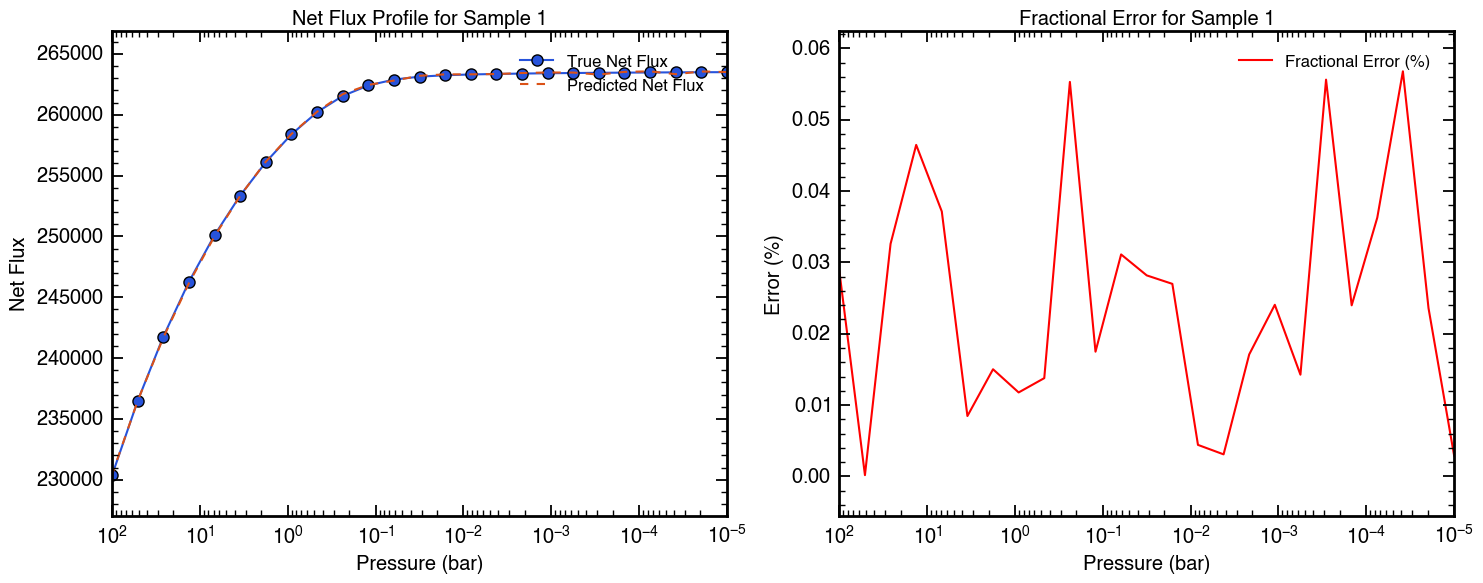

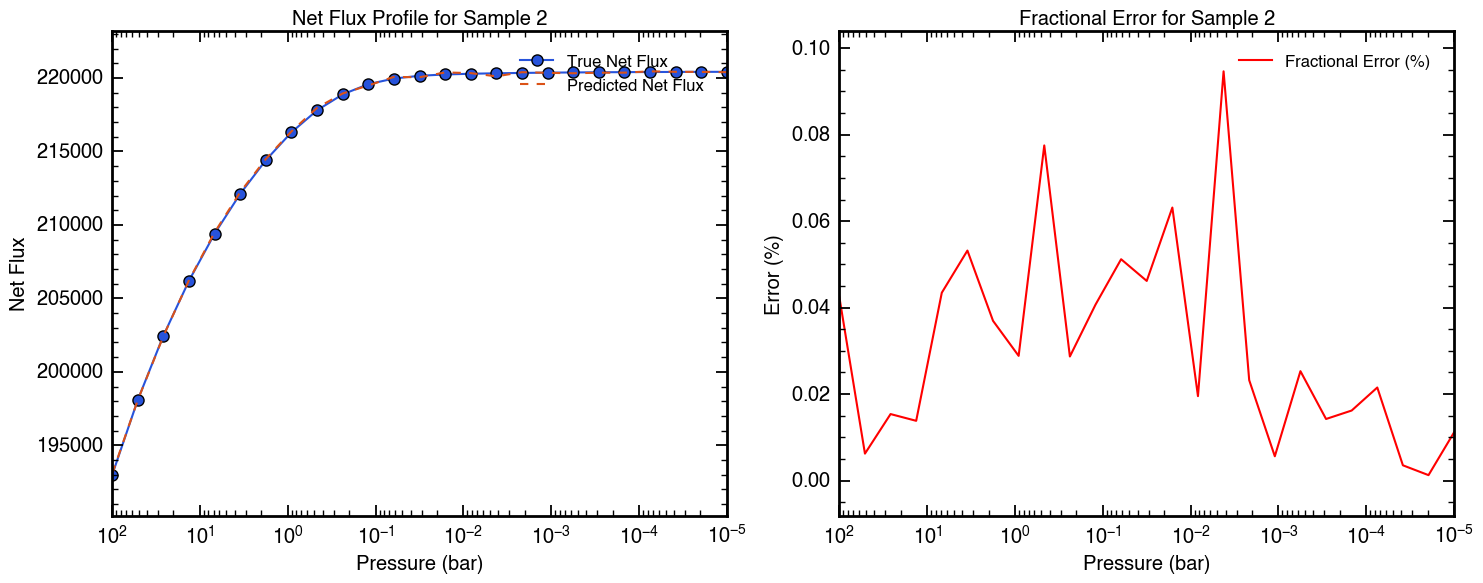

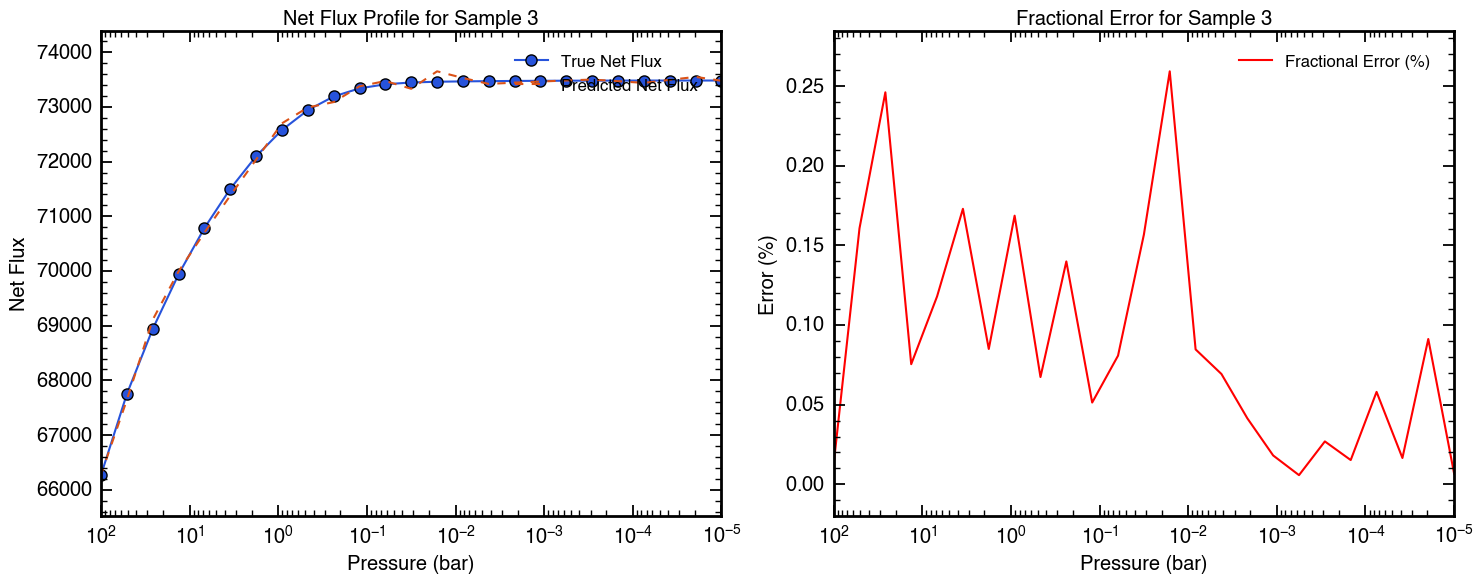

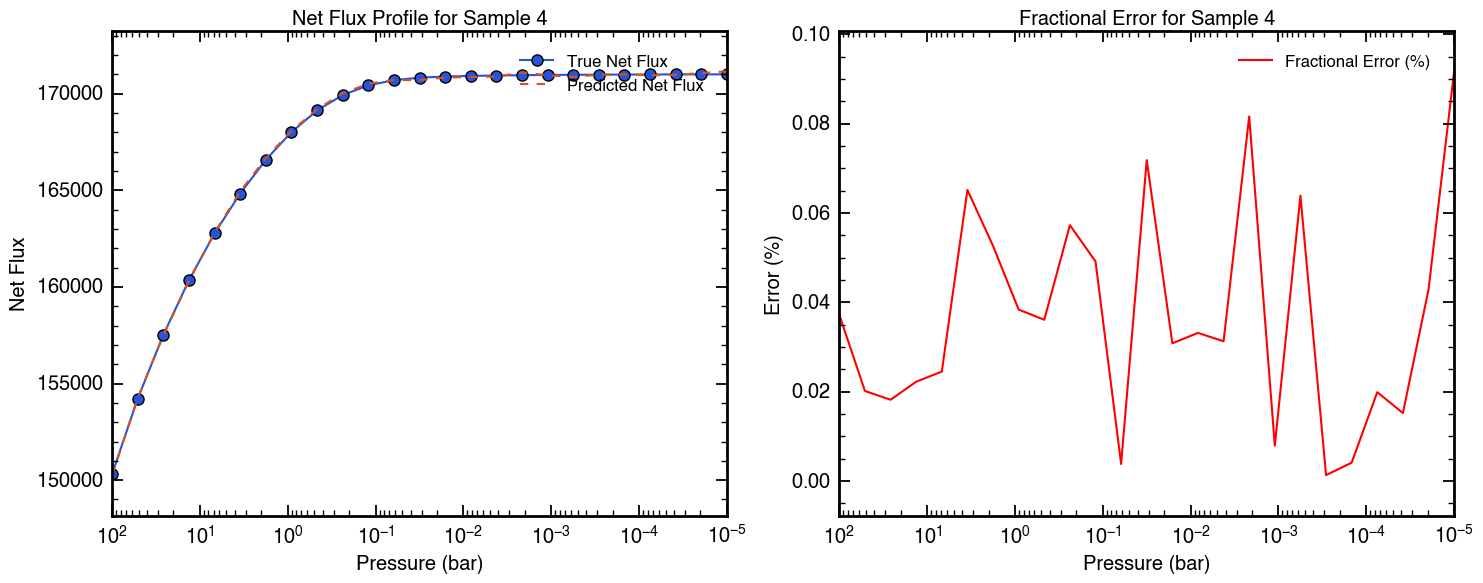

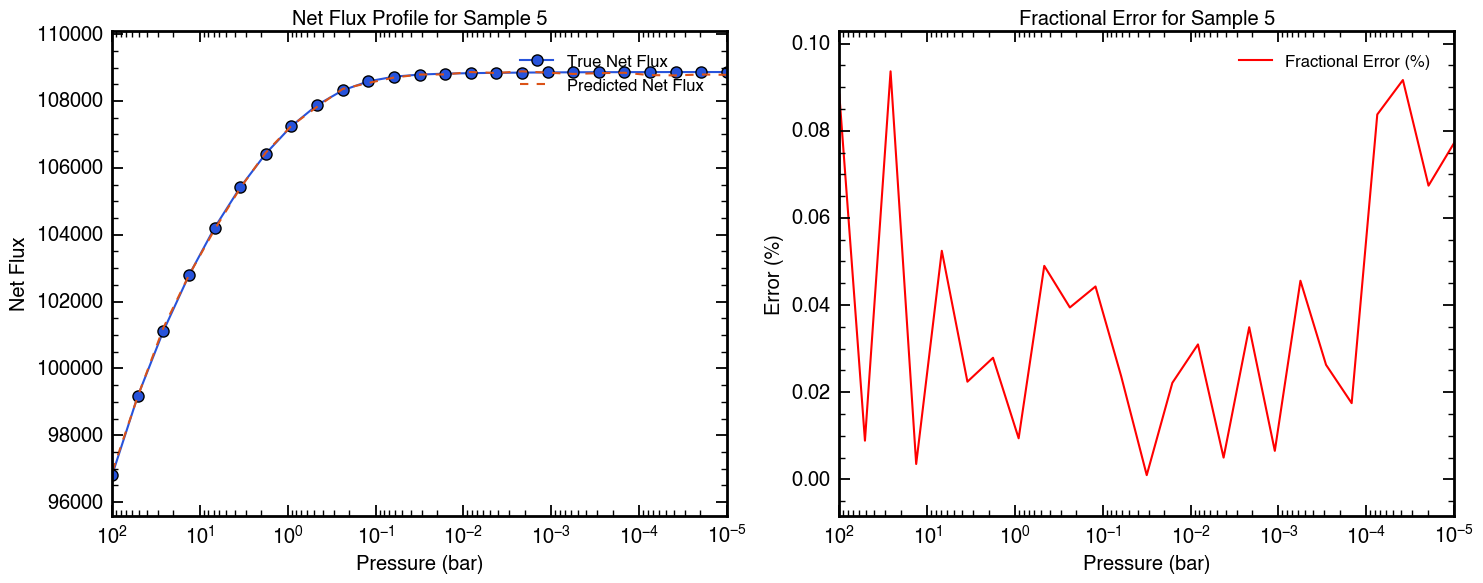

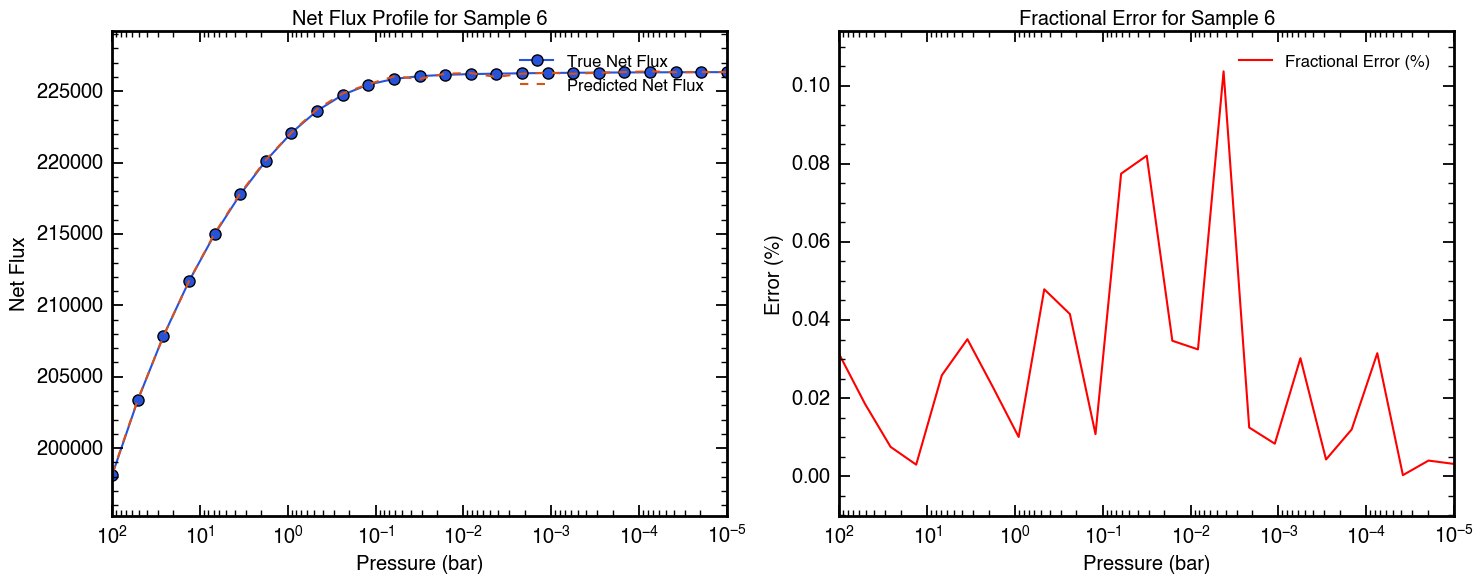

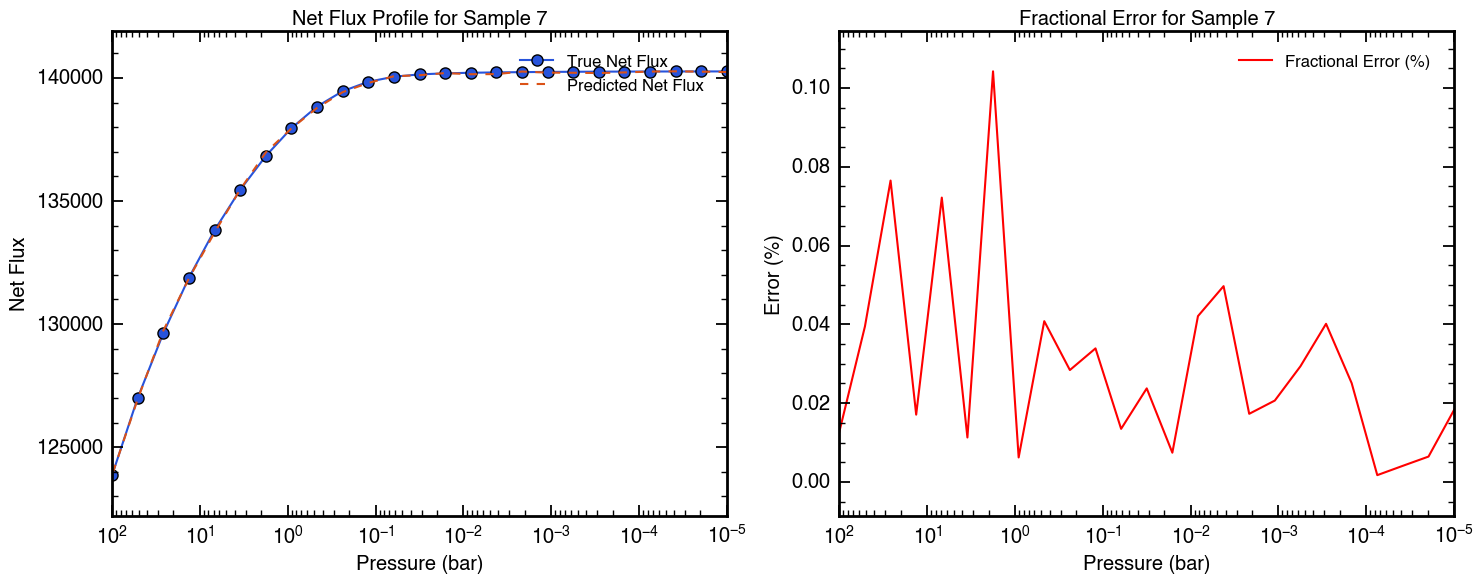

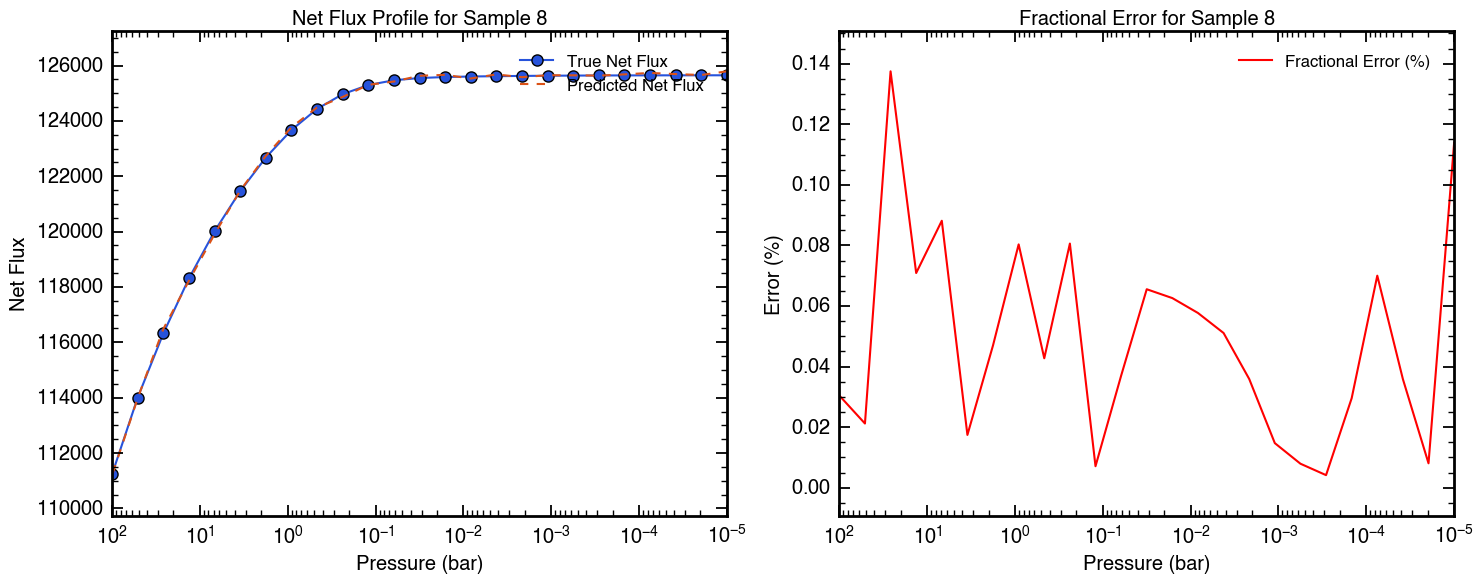

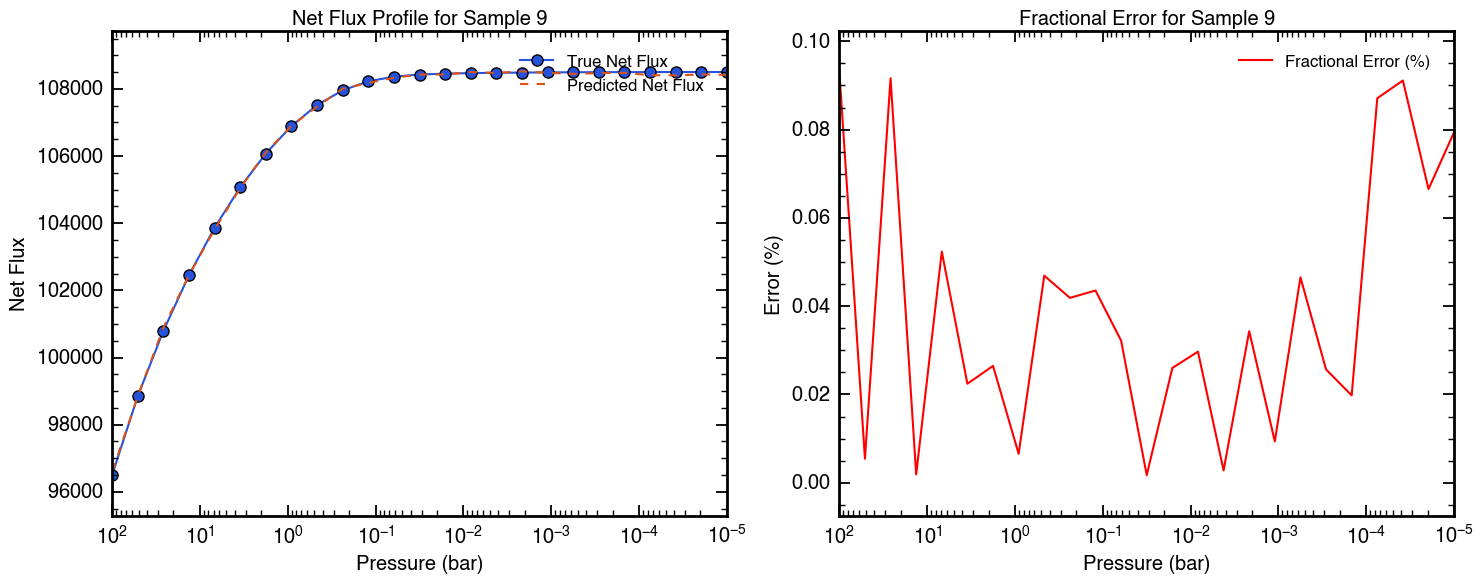

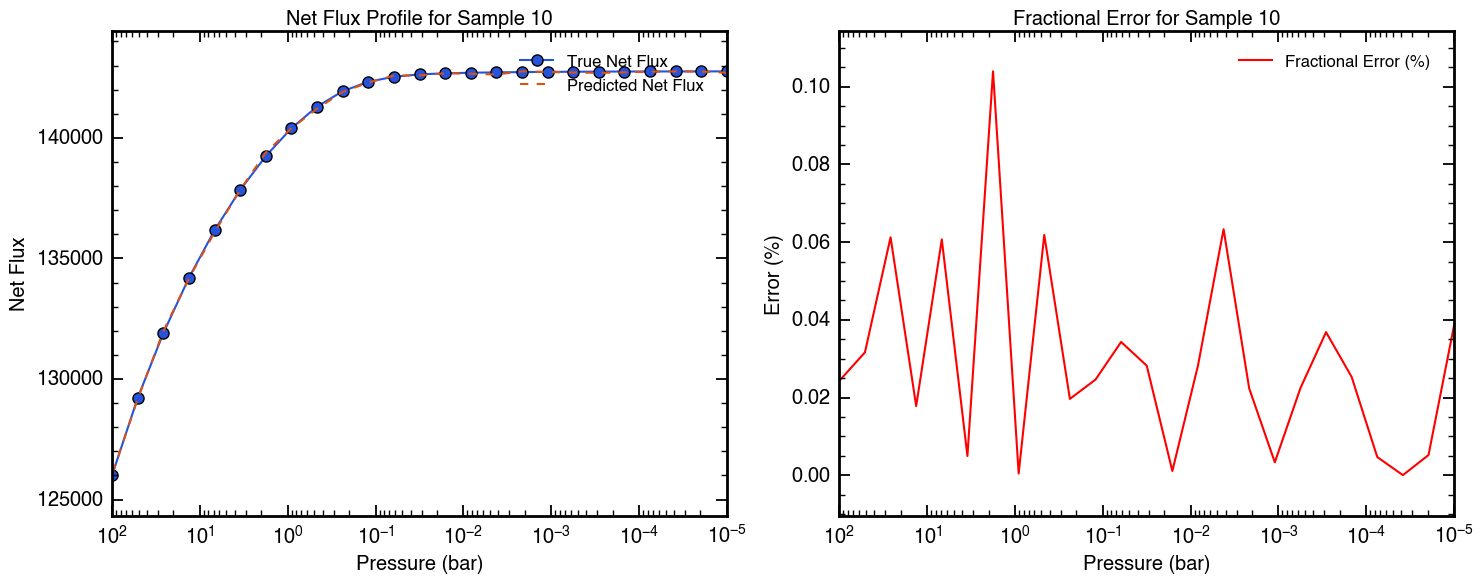

In [6]:
# Number of profiles to visualize
N = 10

# Create a directory for saving plots if it doesn't exist
os.makedirs(save_path, exist_ok=True)

with torch.no_grad():
    for idx, data in enumerate(test_loader):
        if idx >= N:
            break

        # Unpack data, ignoring extra elements if necessary
        if model_type == 'RNN_New':
            inputs, targets = data
        elif model_type == 'BasicRNN':
            inputs, targets, *_ = data  # Ignore any extra elements
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        # Move data to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Verify input feature size matches model expectation
        expected_nx = model_params['nx']
        actual_nx = inputs.size(-1)
        if actual_nx != expected_nx:
            raise ValueError(
                f"Input feature size mismatch: Model expects nx={expected_nx}, but got input with nx={actual_nx}. "
                "Ensure include_Tstar is consistent between training and evaluation."
            )

        # Get model predictions
        outputs = model(inputs_main=inputs)

        # Move tensors to CPU and convert to numpy
        inputs_np = inputs.cpu().numpy()
        targets_np = targets.cpu().numpy()
        outputs_np = outputs.cpu().numpy()

        # Denormalize pressure
        pressure_norm = inputs_np[:, :, 0]  # Assuming pressure is the first feature
        pressure = denormalize_pressure(pressure_norm, normalization_metadata)

        # Denormalize net flux
        net_flux_true = denormalize_net_flux(targets_np.squeeze(), normalization_metadata)
        net_flux_pred = denormalize_net_flux(outputs_np.squeeze(), normalization_metadata)

        # Calculate fractional error
        fractional_error = np.abs(net_flux_pred - net_flux_true) / (np.abs(net_flux_true) + 1e-8)

        # Plotting
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Plot true vs predicted net flux
        axes[0].plot(pressure[0], net_flux_true, label='True Net Flux', marker='o')
        axes[0].plot(pressure[0], net_flux_pred, label='Predicted Net Flux', linestyle='--')
        axes[0].set_xscale('log')
        axes[0].invert_xaxis()
        axes[0].set_xlabel('Pressure (bar)')
        axes[0].set_ylabel('Net Flux')
        axes[0].set_title(f'Net Flux Profile for Sample {idx+1}')
        axes[0].legend()

        # Plot fractional error
        axes[1].plot(pressure[0], fractional_error * 100, label='Fractional Error (%)', color='red')
        axes[1].set_xscale('log')
        axes[1].invert_xaxis()
        axes[1].set_xlabel('Pressure (bar)')
        axes[1].set_ylabel('Error (%)')
        axes[1].set_title(f'Fractional Error for Sample {idx+1}')
        axes[1].legend()

        plt.tight_layout()
        plt.savefig(os.path.join(save_path, f'net_flux_profile_{idx+1}.png'), dpi=300)
        plt.show()
